## Plotting burnt area over time

In [3]:
!conda init bash
!conda activate conFIRE


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




In [2]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation
import cftime
import nc_time_axis
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs
from   libs.plot_maps    import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load in burnt area data

In [3]:
dir = '../outputs/model_runs/'
file = 'canopy.nc'

cubes = iris.load_cube(dir + file, 'burnt_area')


In [4]:
print(cubes)

burnt_area / (1)                    (time: 168; latitude: 144; longitude: 192)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Auxiliary coordinates:
          forecast_period                x              -               -
     Scalar coordinates:
          forecast_reference_time: 1850-01-01 00:00:00
     Attributes:
          Conventions: CF-1.5


Plot when collapsed over time 

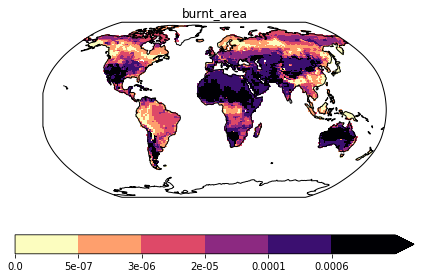

In [5]:
canopy_lon_lat = cubes.collapsed('time', iris.analysis.MEAN)
plot_lonely_cube(canopy_lon_lat, cmap = 'magma_r', levels = None)

Timeline plot of burnt_area

In [15]:
# Aim: find the min of each year, then the mean of that

# iris.coord_categorisation.add_year(cubes, 'time', name='year')

canopy_t = cubes.collapsed(['longitude','latitude'], iris.analysis.SUM)
canopy_yr = canopy_t.aggregated_by(['year'],iris.analysis.MEAN)
print(canopy_yr)    

burnt_area / (1)                    (time: 14)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          forecast_period                x
          month                          x
          year                           x
     Scalar coordinates:
          forecast_reference_time: 1850-01-01 00:00:00
          latitude: 0.0 degrees, bound=(-89.375, 89.375) degrees
          longitude: 180.9375 degrees, bound=(0.9375, 360.9375) degrees
     Attributes:
          Conventions: CF-1.5
     Cell methods:
          sum: longitude, latitude
          mean: year


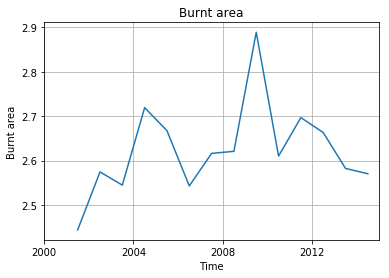

In [19]:
qplt.plot(canopy_yr)
plt.xlim(t_start, t_fin)
plt.grid()
# plt.xticks(xtick)

qplt.show()

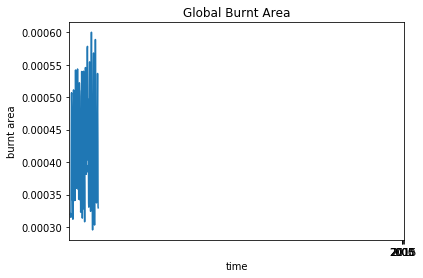

In [46]:
dat = canopy_t.data

plt.plot(dat)
plt.xlabel('time')
plt.ylabel('burnt area')
plt.title('Global Burnt Area')
plt.xticks([2000,2005,2010,2015])
plt.show()

In [54]:
print(canopy_t.coord)

<bound method Cube.coord of <iris 'Cube' of burnt_area / (1) (time: 168)>>
